# TimeSeriesMatrix チュートリアル

`TimeSeriesMatrix` は `SeriesMatrix` を TimeSeries 用に拡張した 3 次元配列コンテナです（shape: Nrow × Ncol × Nsample）。

- `dt / t0 / times` など TimeSeries 互換のエイリアス
- 要素アクセスで `TimeSeries` を返す（`tsm[i, j]`）
- 時間領域処理（detrend/bandpass/resample ...）を要素ごとに適用
- FFT/PSD/ASD や coherence などのスペクトル解析（返り値は `FrequencySeriesMatrix`）
- 表示系 (`plot`, `step`, `repr`, `_repr_html_`) をそのまま使用

このノートブックでは追加のユーティリティ関数は定義せず、クラスメソッドを直接呼び出して動作を確認します。

In [1]:
#%matplotlib inline
#from matplotlib_inline.backend_inline import set_matplotlib_formats
#set_matplotlib_formats("svg")
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline", force=True)

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from IPython.display import display

import sys
from pathlib import Path

# Allow `import gwexpy` when running this notebook from `examples/`.
cwd = Path.cwd().resolve()
for p in [cwd, *cwd.parents]:
    if (p / "gwexpy").is_dir():
        p_str = str(p)
        if p_str not in sys.path:
            sys.path.insert(0, p_str)
        break

from gwexpy.timeseries import TimeSeriesMatrix, TimeSeries

np.set_printoptions(precision=4, suppress=True)
plt.rcParams.update({"figure.figsize": (5, 3), "axes.grid": True})


## 代表データを用意
- 2×2 の `TimeSeriesMatrix` を作り、`dt/t0/times` やメタデータ（unit/name/channel）を確認します。

In [2]:
rng = np.random.default_rng(0)

# サンプル設定
n = 1024
dt = (1 / 256) * u.s
t0 = 0 * u.s

t = (np.arange(n) * dt).to_value(u.s)

tone10 = np.sin(2 * np.pi * 10 * t)
tone20 = np.sin(2 * np.pi * 20 * t + 0.3)

data = np.empty((2, 2, n), dtype=float)
data[0, 0] = 0.5 * tone10 + 0.05 * rng.normal(size=n)
data[0, 1] = 0.5 * tone20 + 0.05 * rng.normal(size=n)
data[1, 0] = 0.3 * tone10 + 0.3 * tone20 + 0.05 * rng.normal(size=n)
data[1, 1] = 0.2 * tone10 - 0.4 * tone20 + 0.05 * rng.normal(size=n)

units = np.full((2, 2), u.V)
names = [["ch00", "ch01"], ["ch10", "ch11"]]
channels = [["X:A", "X:B"], ["Y:A", "Y:B"]]

tsm = TimeSeriesMatrix(
    data,
    dt=dt,
    t0=t0,
    units=units,
    names=names,
    channels=channels,
    rows={"r0": {"name": "row0"}, "r1": {"name": "row1"}},
    cols={"c0": {"name": "col0"}, "c1": {"name": "col1"}},
    name="demo",
)

print(tsm)
print("dt:", tsm.dt, "sample_rate:", tsm.sample_rate, "duration:", tsm.duration)
print("times[:5]:", tsm.times[:5])
display(tsm)


SeriesMatrix(shape=(2, 2, 1024),  name='demo')
  epoch   : 0.0
  x0      : 0.0 s
  dx      : 0.00390625 s
  xunit   : s
  samples : 1024

[ Row metadata ]
     name channel unit
key                   
r0   row0             
r1   row1             

[ Column metadata ]
     name channel unit
key                   
c0   col0             
c1   col1             

[ Elements metadata ]
  unit  name channel  row  col
0    V  ch00     X:A    0    0
1    V  ch01     X:B    0    1
2    V  ch10     Y:A    1    0
3    V  ch11     Y:B    1    1
dt: 0.00390625 s sample_rate: 256.0 Hz duration: 3.99609375 s
times[:5]: [0.     0.0039 0.0078 0.0117 0.0156] s


<SeriesMatrix shape=(2, 2, 1024) rows=('r0', 'r1') cols=('c0', 'c1')>

## 多様な入力パターン（コンストラクタ例）
`dt/t0` のほか、`sample_rate` や `times`、`TimeSeries` の 2D リスト、`Quantity` 入力などを確認します。

In [3]:
print("=== TimeSeriesMatrix コンストラクタ例 ===")
times = tsm.times

# ケース 1: sample_rate 指定（dt の代わり）
tsm_sr = TimeSeriesMatrix(
    data,
    sample_rate=256 * u.Hz,
    t0=t0,
    units=units,
    names=names,
    channels=channels,
)
print("case1 sample_rate", "dt", tsm_sr.dt, "sample_rate", tsm_sr.sample_rate)

# ケース 2: times 指定（不規則サンプルにも対応）
tsm_times = TimeSeriesMatrix(data, times=times, units=units, names=names)
print("case2 times", "dt", tsm_times.dt, "t0", tsm_times.t0, "N", tsm_times.N_samples)

# ケース 3: TimeSeries の 2D リストから構築
ts00 = TimeSeries(data[0, 0], times=times, unit=u.V, name="ch00", channel="X:A")
ts01 = TimeSeries(data[0, 1], times=times, unit=u.V, name="ch01", channel="X:B")
ts10 = TimeSeries(data[1, 0], times=times, unit=u.V, name="ch10", channel="Y:A")
ts11 = TimeSeries(data[1, 1], times=times, unit=u.V, name="ch11", channel="Y:B")
tsm_from_ts = TimeSeriesMatrix([[ts00, ts01], [ts10, ts11]])
print("case3 from TimeSeries", tsm_from_ts.shape, "dt", tsm_from_ts.dt)

# ケース 4: Quantity 入力（units を自動設定）
tsm_q = TimeSeriesMatrix((data * u.mV), dt=dt, t0=t0)
print("case4 Quantity meta unit", tsm_q.meta[0, 0].unit)

# 例外: dt と sample_rate / t0 と epoch は同時指定できない
for kwargs in [
    dict(dt=dt, sample_rate=256 * u.Hz, t0=t0),
    dict(dt=dt, t0=t0, epoch=t0),
]:
    try:
        _ = TimeSeriesMatrix(data, **kwargs)
    except Exception as e:
        print("error", kwargs, "->", type(e).__name__, e)


=== TimeSeriesMatrix コンストラクタ例 ===
case1 sample_rate dt 0.00390625 s sample_rate 256.0 Hz
case2 times dt 0.00390625 s t0 0.0 s N 1024
case3 from TimeSeries (2, 2, 1024) dt 0.00390625 s
case4 Quantity meta unit mV
error {'dt': <Quantity 0.0039 s>, 'sample_rate': <Quantity 256. Hz>, 't0': <Quantity 0. s>} -> ValueError give only one of sample_rate or dt
error {'dt': <Quantity 0.0039 s>, 't0': <Quantity 0. s>, 'epoch': <Quantity 0. s>} -> ValueError give only one of epoch or t0


## 参照・切り出し
- `tsm[i, j]` は `TimeSeries` を返す
- スライスは `TimeSeriesMatrix` を返す
- row/col ラベルでもアクセスできる

[0,0] type <class 'gwexpy.timeseries.timeseries.TimeSeries'> dt 0.00390625 s t0 0.0 s unit V
[0,0] name ch00 channel X:A
[r0,c1] name ch01 channel X:B
tsm[:,0] -> <class 'gwexpy.timeseries.timeseries.TimeSeriesMatrix'> (2, 1, 1024)


/home/washimi/mambaforge/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)


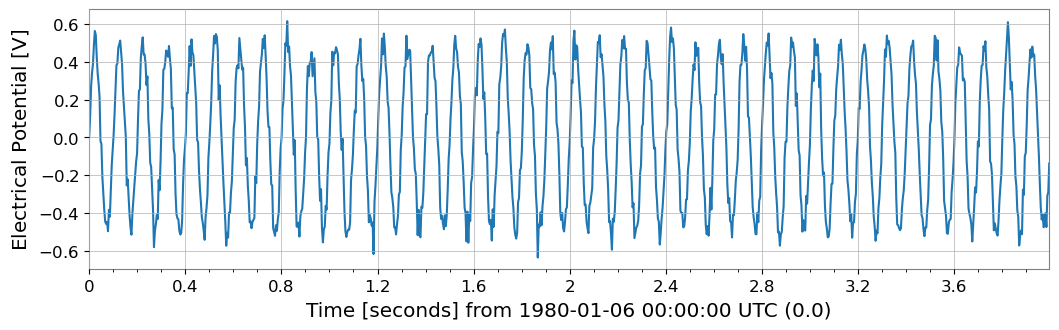

/home/washimi/mambaforge/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


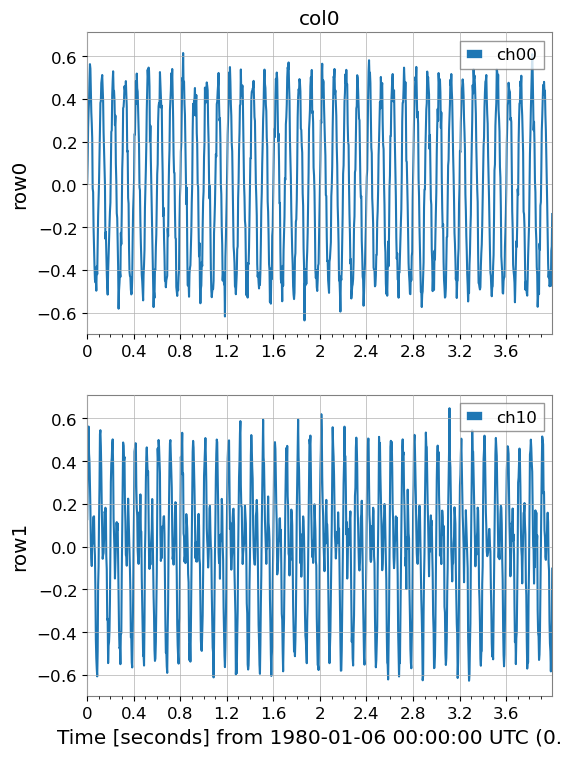

In [4]:
s00 = tsm[0, 0]
print("[0,0]", "type", type(s00), "dt", s00.dt, "t0", s00.t0, "unit", s00.unit)
print("[0,0]", "name", s00.name, "channel", s00.channel)
s00.plot(xscale="seconds");

s01 = tsm["r0", "c1"]
print("[r0,c1]", "name", s01.name, "channel", s01.channel)

sub = tsm[:, 0]
print("tsm[:,0] ->", type(sub), sub.shape)
sub.plot(subplots=True, xscale="seconds");


## サンプル軸編集
- `diff` / `pad` は `TimeSeriesMatrix` を返す
- `crop` は現在 `SeriesMatrix` を返すので、`view(TimeSeriesMatrix)` で戻します（中身は同じ）

cropped <class 'gwexpy.timeseries.timeseries.TimeSeriesMatrix'> (2, 2, 256) span (<Quantity 1. s>, <Quantity 2. s>)
diffed (2, 2, 1023) dt 0.00390625 s
padded (2, 2, 1124) t0 -0.1953125 s


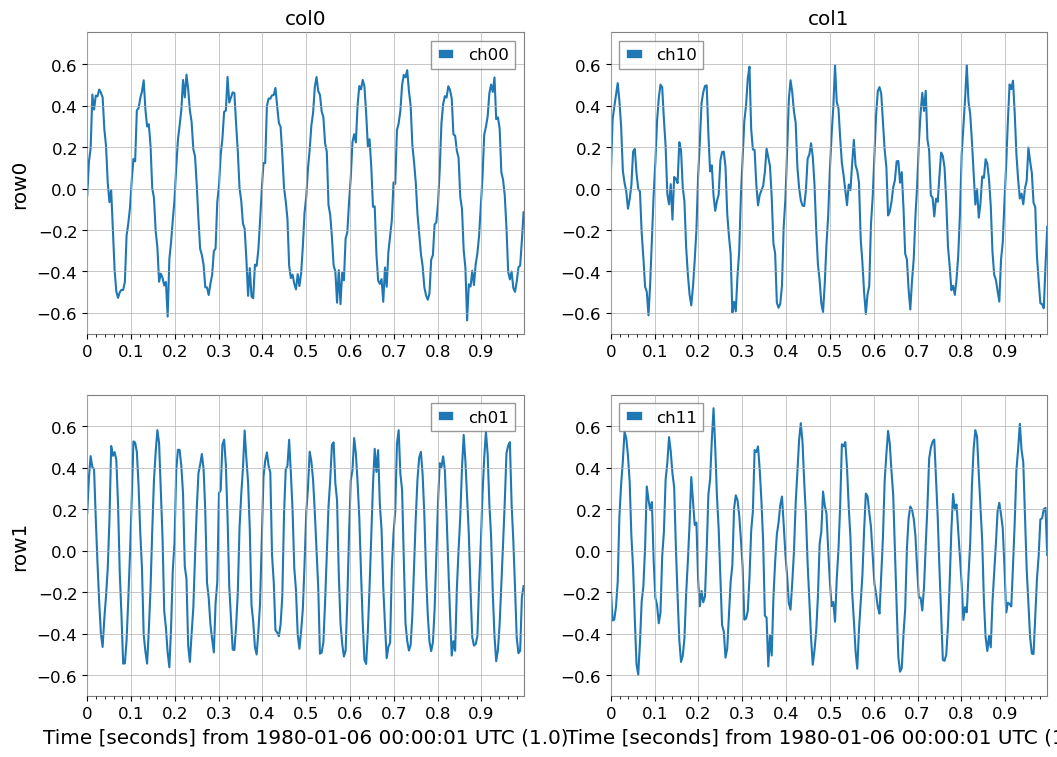

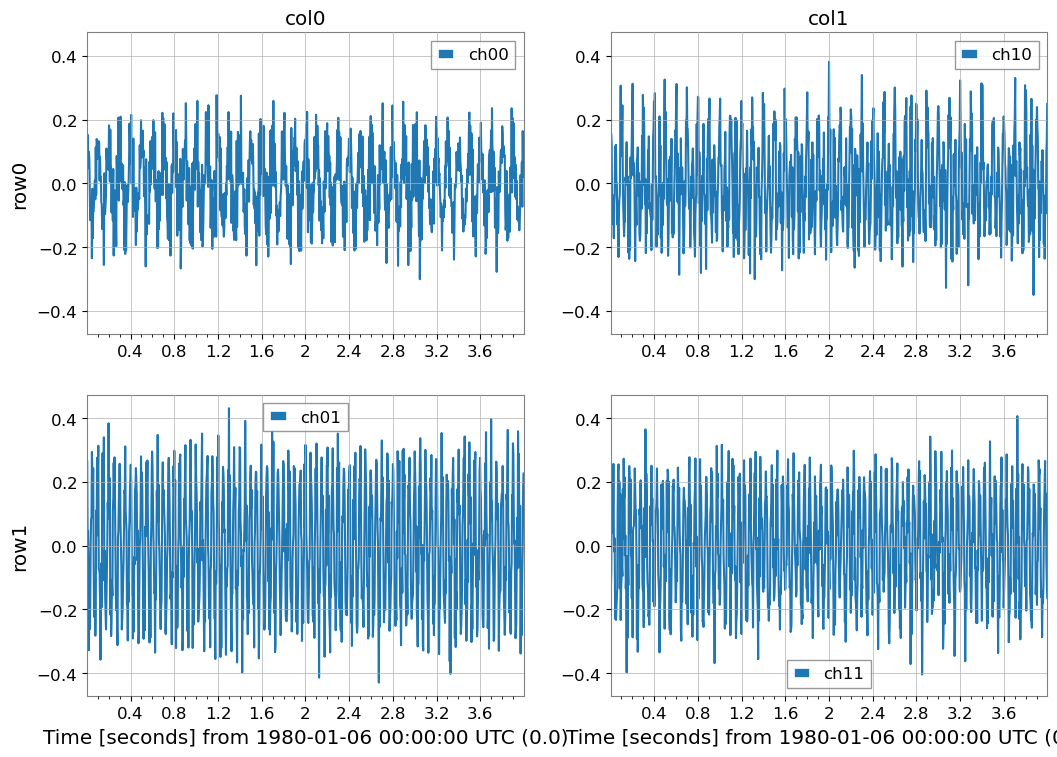

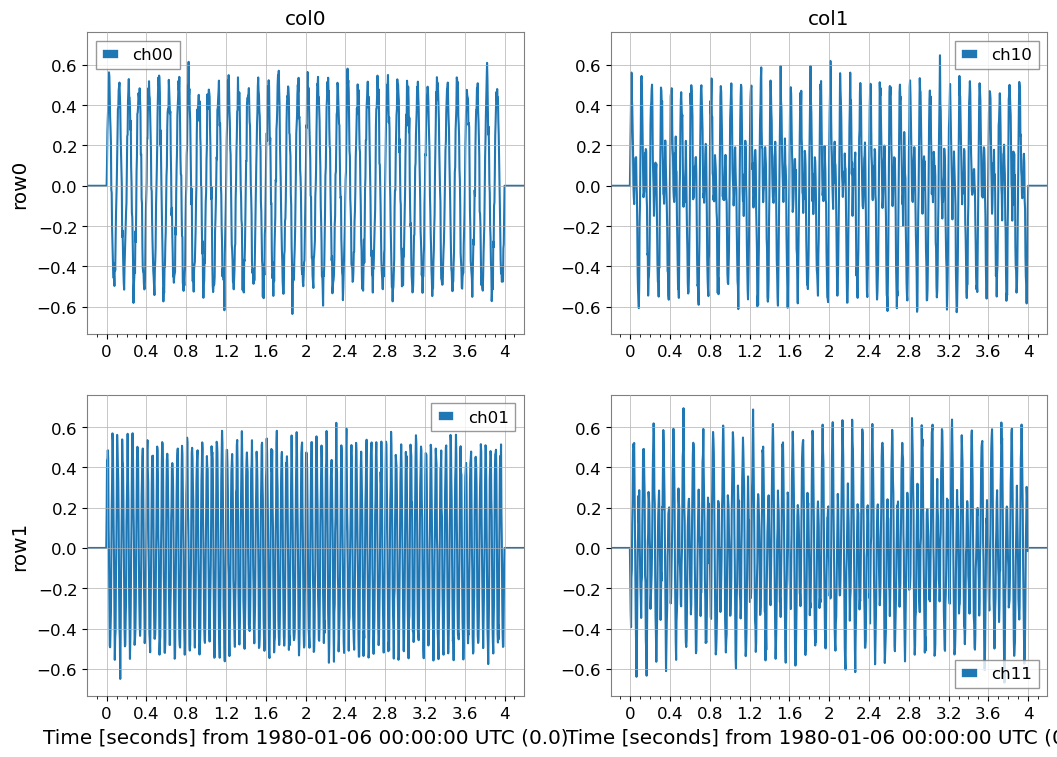

In [5]:
cropped = tsm.crop(start=1 * u.s, end=2 * u.s).view(TimeSeriesMatrix)
print("cropped", type(cropped), cropped.shape, "span", cropped.span)
cropped.plot(subplots=True, xscale="seconds");

diffed = tsm.diff(n=1)
print("diffed", diffed.shape, "dt", diffed.dt)
diffed.plot(subplots=True, xscale="seconds");

padded = tsm.pad(50)
print("padded", padded.shape, "t0", padded.t0)
padded.plot(subplots=True, xscale="seconds");


## 時間領域処理（TimeSeries メソッドの要素ごと適用）
`TimeSeries` のメソッド（`detrend`, `bandpass`, `resample` など）を行列要素ごとに適用します。

original (2, 2, 1024) sample_rate 256.0 Hz
bandpass (2, 2, 1024) sample_rate 256.0 Hz
resample (2, 2, 512) sample_rate 128.0 Hz


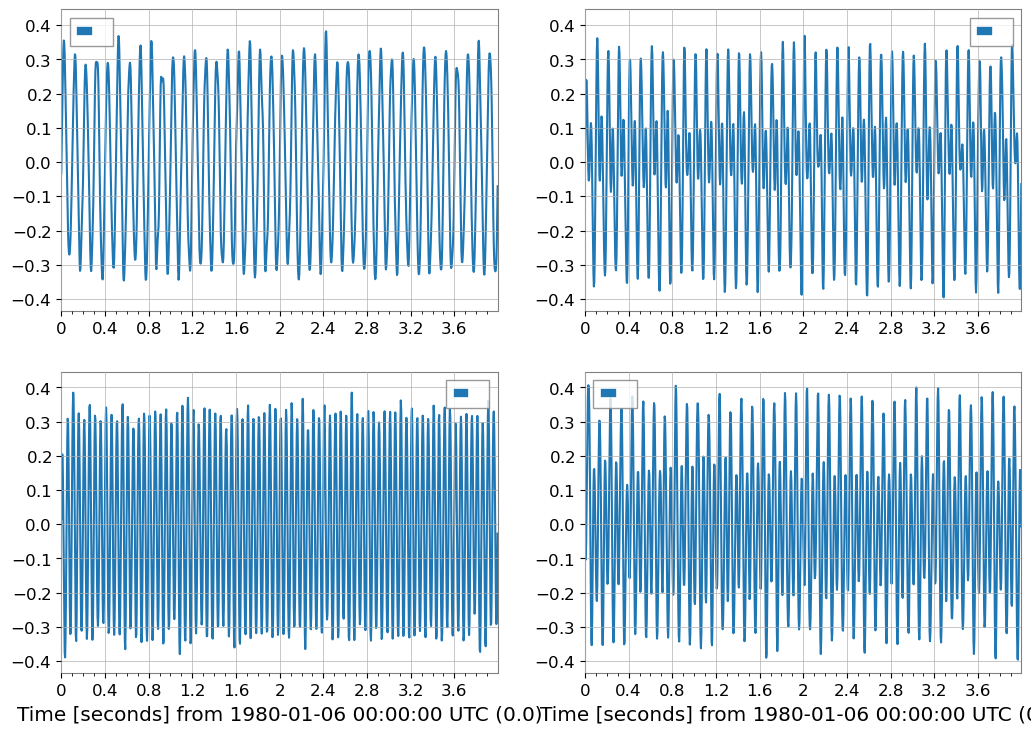

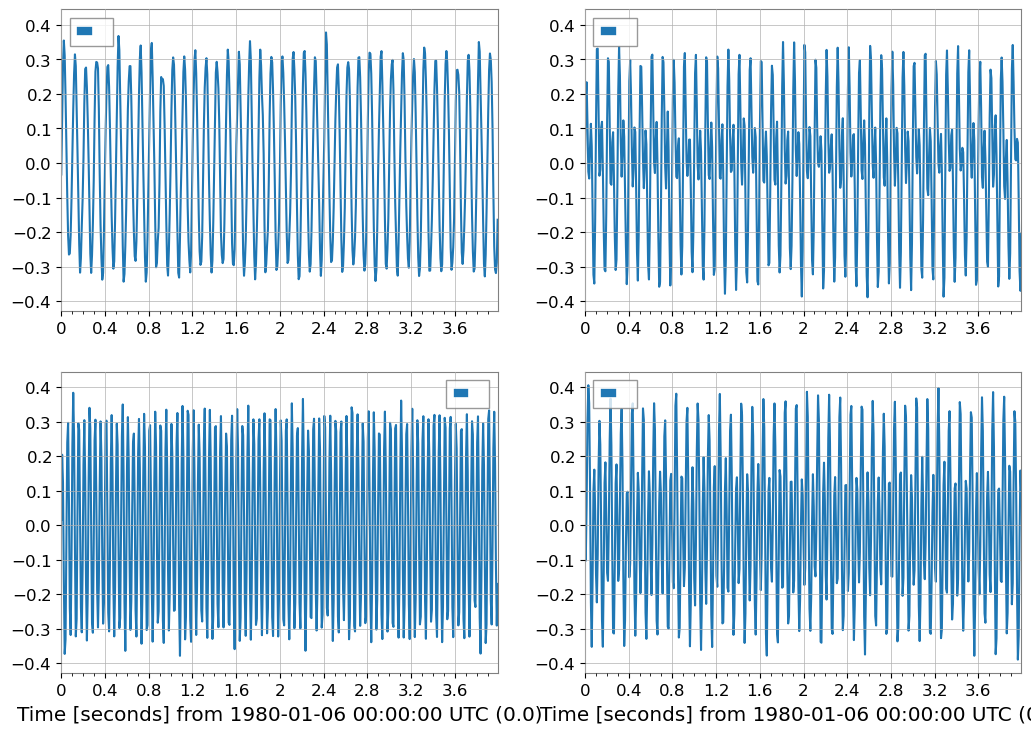

In [6]:
detr = tsm.detrend("constant")
bp = detr.bandpass(5, 40)
rs = bp.resample(128)

print("original", tsm.shape, "sample_rate", tsm.sample_rate)
print("bandpass", bp.shape, "sample_rate", bp.sample_rate)
print("resample", rs.shape, "sample_rate", rs.sample_rate)

bp.plot(subplots=True, xscale="seconds");
rs.plot(subplots=True, xscale="seconds");


## 欠損値処理 (Imputation)
Matrix内の欠損値 (NaN) を補完します。各チャンネルごとに適用されます。

In [7]:
# 欠損値を含むデータの作成 (デモ用)
tsm_miss = tsm.copy()
# 最初のチャンネルの一部をNaNにする (アクセスの仕方に注意: tsm[0,0] は time series)
tsm_miss[0, 0].value[50:60] = np.nan

print("Before impute (Has NaN):", np.isnan(tsm_miss[0,0].value).any())

# 補完 (線形補間)
tsm_imp = tsm_miss.impute(method="interpolate")
print("After impute (Has NaN):", np.isnan(tsm_imp[0,0].value).any())



Before impute (Has NaN): False
After impute (Has NaN): False


## 前処理: 標準化と白色化
多変量解析の前処理として有用です。

In [8]:
# 標準化 (Standardize): 平均0, 分散1にスケーリング
tsm_std = tsm.standardize(method="zscore")

# 白色化 (Whiten): チャンネル間の相関(共分散)を除去
# PCAを用いて無相関化します
tsm_white, w_model = tsm_std.whiten_channels(return_model=True)

print("Standardized shape:", tsm_std.shape)
print("Whitened shape:", tsm_white.shape)



Standardized shape: (2, 2, 1024)
Whitened shape: (4, 1, 1024)


## 成分分解 (PCA / ICA)
効率的な次元圧縮や、信号源分離を行います。

In [9]:
# 主成分分析 (PCA)
# 次元を圧縮 (例: 3チャンネル -> 2主成分)
n_comp = min(2, tsm.shape[0])
pca_scores, pca_res = tsm_std.pca(n_components=n_comp, return_model=True)

print("PCA Scores shape:", pca_scores.shape)
print("Explained variance ratio:", pca_res.explained_variance_ratio)

# 独立成分分析 (ICA)
# 信号源分離 (Blind Source Separation)
ica_sources = tsm_std.ica(n_components=n_comp, random_state=42)
print("ICA Sources shape:", ica_sources.shape)



PCA Scores shape: (2, 1, 1024)
Explained variance ratio: [0.5713 0.4174]
ICA Sources shape: (2, 1, 1024)


/home/washimi/mambaforge/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:589: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn("Ignoring n_components with whiten=False.")


## 相互運用性 (Interop) 入門
PyTorchなどの外部ライブラリへデータを渡すことができます。

In [10]:
try:
    # PyTorch Tensorへ変換
    import torch
    tensor = tsm.to_torch()
    print("Converted to PyTorch:", tensor.shape)
except ImportError:
    print("PyTorch not installed")



Converted to PyTorch: torch.Size([2, 2, 1024])


## スペクトル解析（FFT / PSD / ASD）
`fft/psd/asd` は `FrequencySeriesMatrix` を返します。

fft <class 'gwexpy.frequencyseries.frequencyseries.FrequencySeriesMatrix'> (2, 2, 513) df 0.25 Hz f0 0.0 Hz
psd (2, 2, 129) unit V2 / Hz
asd (2, 2, 129) unit V / Hz(1/2)


/home/washimi/mambaforge/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/washimi/mambaforge/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


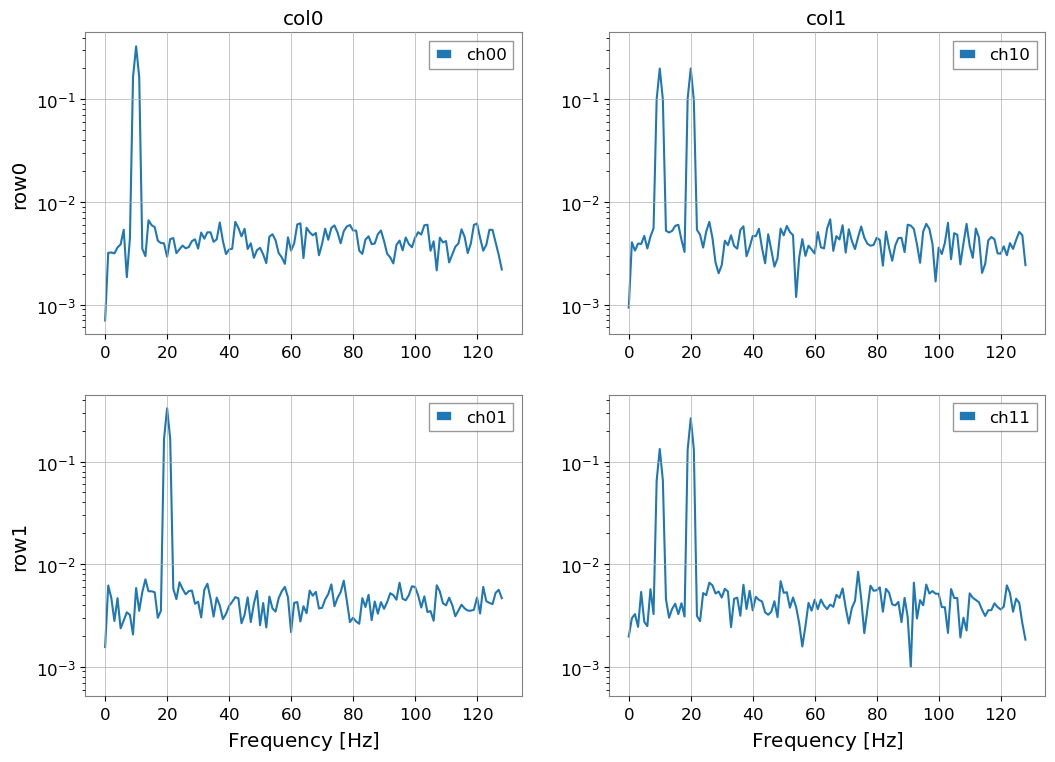

In [11]:
fft = tsm.fft()
print("fft", type(fft), fft.shape, "df", fft.df, "f0", fft.f0)

psd = tsm.psd(fftlength=1, overlap=0.5)
asd = tsm.asd(fftlength=1, overlap=0.5)
print("psd", psd.shape, "unit", psd[0, 0].unit)
print("asd", asd.shape, "unit", asd[0, 0].unit)

asd.plot(subplots=True);


## bivariate スペクトル解析（coherence 例）
`TimeSeriesMatrix.coherence(other)` は要素ごとに coherence を計算し、`FrequencySeriesMatrix` を返します。

- `other` に `TimeSeries` を渡すと「全要素 vs 同一参照」の比較になります
- `other` に `TimeSeriesMatrix` を渡す場合は shape (Nrow, Ncol) が一致している必要があります

coherence <class 'gwexpy.frequencyseries.frequencyseries.FrequencySeriesMatrix'> (2, 2, 129) unit coherence
shape mismatch -> ValueError shape mismatch: (2, 2) vs (2, 1)


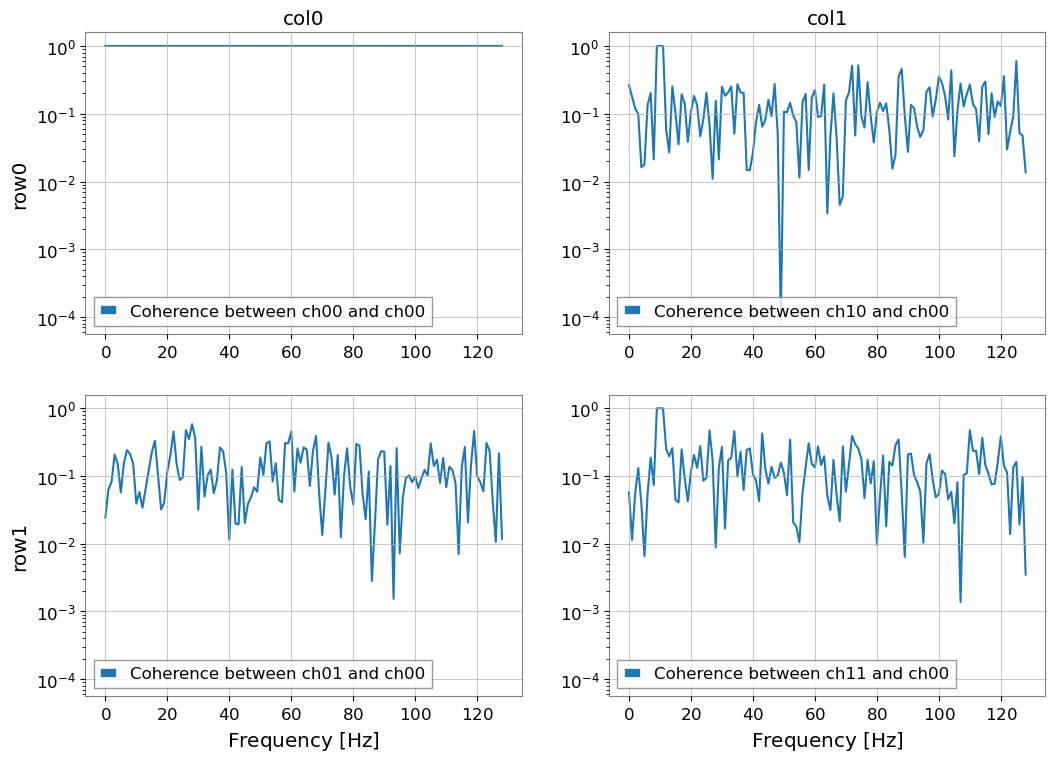

In [12]:
ref = tsm[0, 0]
coh = tsm.coherence(ref, fftlength=1, overlap=0.5)
print("coherence", type(coh), coh.shape, "unit", coh[0, 0].unit)
coh.plot(subplots=True);

try:
    _ = tsm.coherence(tsm[:, :1], fftlength=1)
except Exception as e:
    print("shape mismatch ->", type(e).__name__, e)


## 表示系: repr / plot / step
- `repr`: テキスト表示
- `_repr_html_`: ノートブックでは `display(tsm)` で表形式
- `plot` / `step`: クラスメソッドで直接描画（保存はしない）

repr:
 SeriesMatrix(shape=(2, 2, 1024),  name='demo')
  epoch   : 0.0
  x0      : 0.0 s
  dx      : 0.00390625 s
  xunit   : s
  samples : 1024

[ Row metadata ]
     name channel unit
key                   
r0   row0             
r1   row1             

[ Column metadata ]
     name channel unit
key                   
c0   col0             
c1   col1             

[ Elements metadata ]
  unit  name channel  row  col
0    V  ch00     X:A    0    0
1    V  ch01     X:B    0    1
2    V  ch10     Y:A    1    0
3    V  ch11     Y:B    1    1


<SeriesMatrix shape=(2, 2, 1024) rows=('r0', 'r1') cols=('c0', 'c1')>

/home/washimi/mambaforge/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/washimi/mambaforge/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


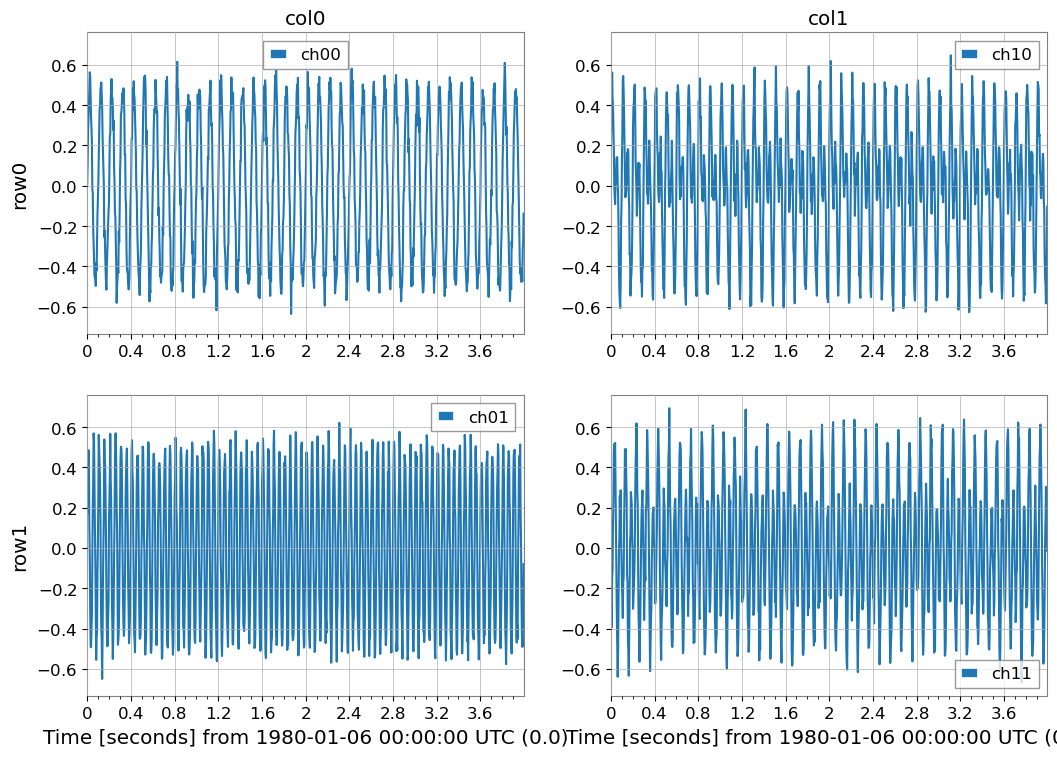

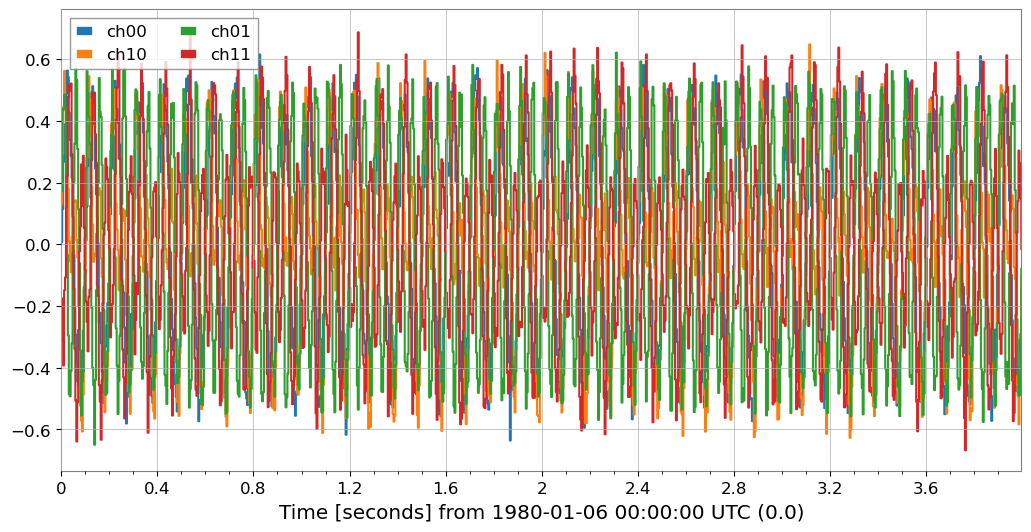

In [13]:
print("repr:\n", tsm)
display(tsm)

tsm.plot(subplots=True, xscale="seconds");
tsm.step(where="post", xscale="seconds");


## まとめ
- `TimeSeriesMatrix` は TimeSeries 互換の軸情報（`dt/t0/times`）と要素メタデータを保ったまま、行列として一括処理できる。
- 時間領域処理（detrend/bandpass/resample 等）やスペクトル解析（asd/psd/coherence 等）を、要素ごとにまとめて適用できる。
- まず `tsm[i, j]` で `TimeSeries` を取り出して挙動を確認し、慣れたら行列のまま処理するのが簡単。